# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [3]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [4]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [5]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [6]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(21, 10, True)
End game! Reward:  1.0
You won :)

(14, 10, False)
End game! Reward:  -1.0
You lost :(

(21, 6, True)
(21, 6, False)
End game! Reward:  1.0
You won :)



### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [7]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [8]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((13, 8, False), 1, 0), ((18, 8, False), 1, -1)]
[((12, 10, False), 1, -1)]
[((15, 6, False), 1, -1)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) `{s0 : [v_a0, v_a1, ...], s1 : [v_a0, v_a1, ...], ...}` where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

The pseudocode for the _first-visit MC prediction_ is:
<img src="../assets/images/first-visit-mc-pred.png" alt="First-visit Monte Carlo Prediction" style="width: 600px;"/>

There are three relevant tables (implemented as dictionaries):

  * $Q$ - $Q$-table, with a row for each state and a column for each action. The entry corresponding to state $s$ and action $a$ is denoted $Q(s,a)$.   
  * $N$ - $N$-table that keeps track of the number of first visits we have made to each state-action pair.   
  * $returns\_sum$ - table that keeps track of the sum of the rewards obtained after first visits to each state-action pair.  

In the algorithm, the number of episodes the agent collects is equal to $num\_episodes$. After each episode, $N$ and $returns\_sum$ are updated to store the information contained in the episode. Then, after all of the episodes have been collected and the values in $N$ and $returns\_sum$ have been finalized, we quickly obtain the final estimate for $Q$.

In [21]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))  # default items are s : [0, 0]
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        #███╗   ██╗ ██████╗ ████████╗███████╗
        #████╗  ██║██╔═══██╗╚══██╔══╝██╔════╝
        #██╔██╗ ██║██║   ██║   ██║   █████╗  
        #██║╚██╗██║██║   ██║   ██║   ██╔══╝  
        #██║ ╚████║╚██████╔╝   ██║   ███████╗
        #╚═╝  ╚═══╝ ╚═════╝    ╚═╝   ╚══════╝
        # http://patorjk.com/software/taag/#p=display&f=ANSI%20Shadow&t=NOTE
        #
        # 1. This is a non-Pythonic implementation of non-discount
        #    return-at-game-end first-visit MC prediction for BJ.
        #    See the next code cell with the official solution.
    
        ## TODO: complete the function
        # - generate episode
        episode = generate_episode(env)
        # sample output:
        # [((13, 8, False), 1, 0), ((18, 8, False), 1, -1)]
        # [((12, 10, False), 1, -1)]
        # [((15, 6, False), 1, -1)]
        
        # Note: For BJ, first-visit and every-visit is the same as the same
        # state never repeats, per the rules of the game. (TODO: Verify)

        # - for each first visit in the episode, update N and returns_sum
        G_episode = episode[-1][2]
        for e in episode:  # Assumes only first visits! (See note above)
            N[e[0]][e[1]] = N[e[0]][e[1]] + 1  # N[s][a] = N[s][a] + 1
            returns_sum[e[0]][e[1]] = returns_sum[e[0]][e[1]] + G_episode
        
    ## TODO
    # - fill out Q
    for s in N.keys():
        Q[s] = returns_sum[s]/N[s]  # itemwise division [r_stick/n_stick, r_hit/n_hit]
        
    return Q

Now, let's study the prescribed implementation:

In [ ]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        #███╗   ██╗ ██████╗ ████████╗███████╗
        #████╗  ██║██╔═══██╗╚══██╔══╝██╔════╝
        #██╔██╗ ██║██║   ██║   ██║   █████╗  
        #██║╚██╗██║██║   ██║   ██║   ██╔══╝  
        #██║ ╚████║╚██████╔╝   ██║   ███████╗
        #╚═╝  ╚═══╝ ╚═════╝    ╚═╝   ╚══════╝
        # http://patorjk.com/software/taag/#p=display&f=ANSI%20Shadow&t=NOTE
        #
        # 1. Because for BJ first-visit and every-visit are equivalent, 
        #    possibly due to the fact that an episode does not have
        #    more than one instance of the same (s, a, •) tuple (verify),
        #    this implementation is for every-visit MC prediction.
        
        # generate an episode
        episode = generate_episode(env)                                                  # !!: a list of (s, a, r) tuples
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)                                         # !!: elegant Pythonic episode unpacking
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])                  # !!: first one is not discounted (gamma=1)
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):                                               # !!: every-visit MC: i indexes the actions
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])        # !!: for general return
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

In [20]:
print(env.action_space.n)

2


In [19]:
d = defaultdict(lambda: np.zeros(env.action_space.n))  # items are s: [0, 0]
for i in d.items():
    print(i)

In [23]:
e = [((13, 8, False), 1, 0), ((18, 8, False), 1, -1)]
states, actions, rewards = zip(*e)
print(states, actions, rewards)

((13, 8, False), (18, 8, False)) (1, 1) (0, -1)


Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

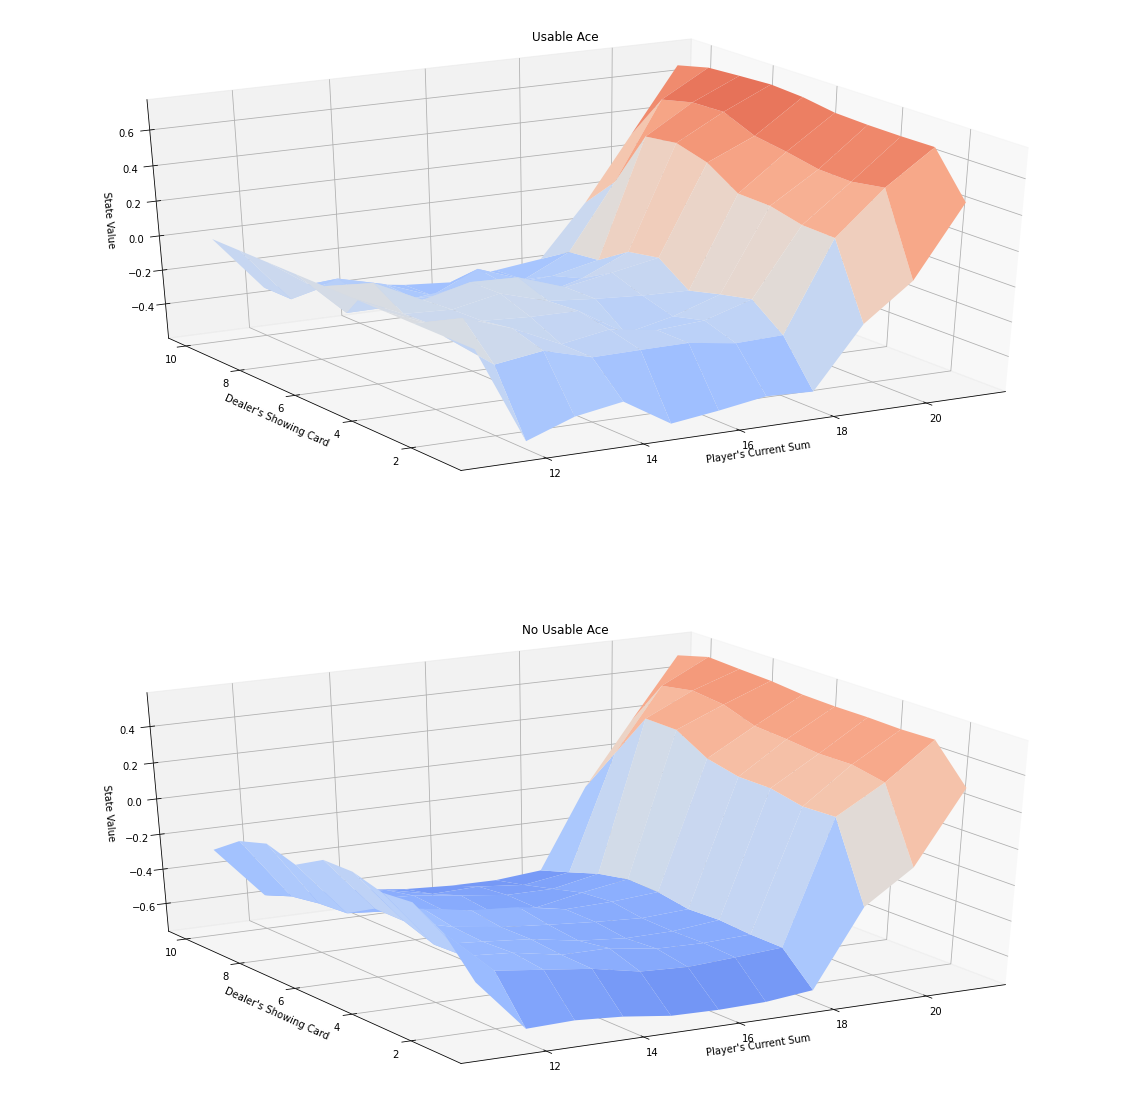

In [22]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

#### Part 2.1: Epsilon-greedy

TODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODO: format and complete

You can think of the agent who follows an \epsilonϵ-greedy policy as always having a (potentially unfair) coin at its disposal, with probability \epsilonϵ of landing heads. After observing a state, the agent flips the coin.

If the coin lands tails (so, with probability 1-\epsilon1−ϵ), the agent selects the greedy action.
If the coin lands heads (so, with probability \epsilonϵ), the agent selects an action uniformly at random from the set of available (non-greedy AND greedy) actions.
In order to construct a policy \piπ that is \epsilonϵ-greedy with respect to the current action-value function estimate QQ, we will set

\pi(a|s) \longleftarrow \begin{cases} \displaystyle 1-\epsilon +\epsilon/|\mathcal{A}(s)|& \textrm{if }a\textrm{ maximizes }Q(s,a)\\ \displaystyle \epsilon/|\mathcal{A}(s)| & \textrm{else} \end{cases}π(a∣s)⟵{ 
1−ϵ+ϵ/∣A(s)∣
ϵ/∣A(s)∣
​	  
if a maximizes Q(s,a)
else
​	 

for each s\in\mathcal{S}s∈S and a\in\mathcal{A}(s)a∈A(s).

#### Part 2.2: Greedy in the Limit with Infinite Exploration (GLIE)

In order to guarantee that MC control converges to the optimal policy $\pi$, we need to ensure that two conditions are met. We refer to these conditions as **Greedy in the Limit with Infinite Exploration (GLIE)**. In particular, if:

  * every state-action pair $s, a$ (for all $s\in\mathcal{S}$ and $a\in\mathcal{A}(s)$) is visited infinitely many times, and   
  * the policy converges to a policy that is greedy with respect to the action-value function estimate $Q$,   

then MC control is guaranteed to converge to the optimal policy (in the limit as the algorithm is run for *infinitely many episodes*). These conditions ensure that:

  * the agent continues to explore for all time steps, and  
  * the agent gradually **exploits** more (and **explores** less).  

One way to satisfy these conditions is to modify the value of $\epsilon$ when specifying an $\epsilon$-greedy policy. In particular, let $\epsilon_i$ correspond to the $i$-th time step. Then, both of these conditions are met if:

  * $\epsilon_i > 0$ for all time steps $i$, and   
  * $\epsilon_i$ decays to zero in the limit as the time step $i$ approaches infinity (that is, $\lim_{i\to\infty} \epsilon_i = 0$.

For example, to ensure convergence to the optimal policy, we could set $\epsilon_i = \frac{1}{i}$. (You are encouraged to verify that $\epsilon_i > 0$ for all $i$, and $\lim_{i\to\infty} \epsilon_i = 0$.)

#### Part 2.3: Incremental mean

In our current algorithm for Monte Carlo control, we collect a large number of episodes to build the $Q$-table (as an estimate for the action-value function corresponding to the agent's current policy). Then, after the values in the $Q$-table have converged, we use the table to come up with an improved policy.

Maybe it would be more efficient to update the $Q$-table *after every episode*. Then, the updated $Q$-table could be used to improve the policy. That new policy could then be used to generate the next episode, and so on.

The pseudocode of the first-visit GLIE MC control is:
<img src="../assets/images/first-visit-glie-mc-control.png" alt="First-visit GLIE Monte Carlo Control" style="width: 600px;"/>

There are two relevant tables:

  * $Q$ - $Q$-table, with a row for each state and a column for each action. The entry corresponding to state $s$ and action $a$ is denoted $Q(s,a)$.   
  * $N$ - table that keeps track of the number of first visits we have made to each state-action pair.   

The number of episodes the agent collects is equal to $num\_episodes$.

The algorithm proceeds by looping over the following steps:

  1. The policy $\pi$ is improved to be $\epsilon$-greedy with respect to $Q$, and the agent uses $\pi$ to collect an episode.   
  2. $N$ is updated to count the total number of first visits to each state action pair.   
  3. The estimates in $Q$ are updated to take into account the most recent information.
  
TODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODO: show update formulae


In this way, the agent is able to improve the policy after every episode!

#### Part 2.4: Constant alpha

TODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODO

The pseudocode of the first-visit constant-$\alpha$ GLIE MC control is:
<img src="../assets/images/first-visit-const-alpha-glie-mc-control.png" alt="First-visit GLIE Monte Carlo Control" style="width: 600px;"/>


(_Feel free to define additional functions to help you to organize your code._)

#### Part 2.5: Implementation

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.



In [ ]:
#████████╗ ██████╗ ██████╗  ██████╗ 
#╚══██╔══╝██╔═══██╗██╔══██╗██╔═══██╗
#   ██║   ██║   ██║██║  ██║██║   ██║
#   ██║   ██║   ██║██║  ██║██║   ██║
#   ██║   ╚██████╔╝██████╔╝╚██████╔╝
#   ╚═╝    ╚═════╝ ╚═════╝  ╚═════╝                                   
# http://patorjk.com/software/taag/#p=display&f=ANSI%20Shadow&t=TODO
#
# 1. Contrast with mc_prediction_q: returns only Q.
#
# 2. Epsilon is not provided as a parameter. Perhaps an internal parameter.
#    The pseudocode explicitly uses a GLIA policy pi to generate episodes,
#    and the epsilon is decayed with each episode. So, need a GLIA policy
#    function of the format of the generate_episode_with_limit_stochastic.

def mc_control(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [ ]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, ?, ?)

Next, we plot the corresponding state-value function.

In [ ]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

In [ ]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)